# Scratchpad

generic notebook used for exploration of the dataset.

In [10]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../") 
import models.utility as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import spacy
import html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopy
import gzip
from scipy import deg2rad
import random
import pandas as pd
import jsonlines
import string
import re
import requests
import os
from collections import Counter

import sklearn.linear_model as linear_model
import sklearn.neighbors as neighbors
import sklearn.gaussian_process as gaussian_process
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
sns.set(style="darkgrid")

In [12]:
nlp = spacy.load('en_core_web_md')

In [13]:
raw_articles, raw_annotations, raw_locations = utils.load_dataset()

articles count: 9959
annotations count: 3221
locations count: 3562


In [16]:
annotation_histogram = Counter()
publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    annotation_histogram[len(raw_doc["annotation_uri"])] += 1
    publisher_histogram[raw_doc["publisher"]] += 1


Let's display the distribution of annotations/locations over the article dataset.

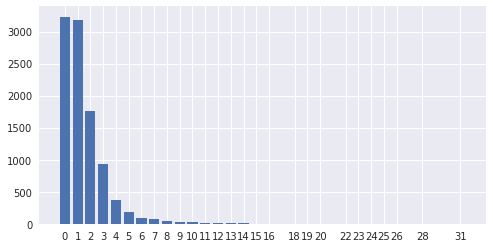

In [17]:
fig = plt.figure(figsize=(8,4))
plt.bar(annotation_histogram.keys(), annotation_histogram.values(),tick_label=[k for k in annotation_histogram.keys()]);


Likewise for the distribution of publishers:

In [18]:
c = 30
print(f"{c} most common publishers: ")
for k,v in publisher_histogram.most_common(c):
    print(k.ljust(35)," | count:" ,v)

30 most common publishers: 
www.birminghammail.co.uk             | count: 191
mirror                               | count: 190
www.manchestereveningnews.co.uk      | count: 181
dailyrecord                          | count: 156
www.coventrytelegraph.net            | count: 156
The Courier                          | count: 154
www.liverpoolecho.co.uk              | count: 152
The Northern Echo                    | count: 143
Eastern Daily Press                  | count: 131
www.walesonline.co.uk                | count: 129
HeraldScotland                       | count: 128
www.chroniclelive.co.uk              | count: 126
Bournemouth Echo                     | count: 126
www.yorkshirepost.co.uk              | count: 123
Evening Times                        | count: 122
www.thestar.co.uk                    | count: 106
This Is Local London                 | count: 98
East Anglian Daily Times             | count: 92
www.yorkshireeveningpost.co.uk       | count: 90
www.glasgowlive.co.uk    

We notice that some publisher may belong to the same group but have different name. for example, "birminghammail" and "birminghammail.com"

We're going to clean up the publishers name to possibly

In [19]:
[a for a in raw_articles if "The Charlton Champion" == a["publisher"]]

[{'iid': 'f020439f-723d-4eec-8bec-9a9309dc1749',
  'lastModifiedTime': 1530456309000,
  'publisher': 'The Charlton Champion',
  'published_time': None,
  'annotation_uri': ['5e5f51d83ca0e75f33f8811727cc90e3',
   '76defb7d20d73da27d65eb10bd976d2a'],
  'id': 'f020439f-723d-4eec-8bec-9a9309dc1749',
  'url': 'https://charltonchampion.co.uk/2018/07/01/rockwell-returns-controversial-charlton-riverside-scheme-to-be-heard-on-9-july/',
  'articleid': None,
  'previous_id': None,
  'type': 'articles',
  'title': 'Rockwell returns: Controversial Charlton Riverside scheme to be heard on 9 July',
  'cleantitle': None,
  'description': 'Plans to redevelop the VIP Trading Estate by developer Rockwell are to go before Greenwich Council’s Planning Board on Monday 9th July,\xa0the original hearing in April being deferred until afte…',
  'body': 'Plans to redevelop the VIP Trading Estate by developer Rockwell are to go before Greenwich Council’s Planning Board on Monday 9th July, the original hearing in 

In [20]:
set([a["publisher"] for a in raw_articles if "birm" in a["publisher"].lower()])

{'birminghammail', 'www.birminghammail.co.uk', 'www.birminghampost.co.uk'}

In [21]:
publishers = set([a["publisher"] for a in raw_articles])

In [22]:
clean_publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    clean_publisher_histogram[utils.clean_publisher(raw_doc["publisher"])] += 1

In [27]:
print("count of publishers:")
print("raw names: ", len(publisher_histogram))
print("clean names:", len(clean_publisher_histogram))
n = 80
print("count of large publishers:")
print("raw names: ", len([p for p, c in publisher_histogram.items() if c > n]))
print("clean names: ", len([p for p, c in clean_publisher_histogram.items() if c > n]))

count of publishers:
raw names:  384
clean names: 377
count of large publishers:
raw names:  23
clean names:  24


In [28]:

print(f"{c} most common publishers: ")
for k,v in clean_publisher_histogram.most_common(c):
    print(k.ljust(35)," | count:" ,v)

30 most common publishers: 
coventrytelegraph                    | count: 234
birminghammail                       | count: 200
mirror                               | count: 190
manchestereveningnews                | count: 181
dailyrecord                          | count: 156
thecourier                           | count: 154
liverpoolecho                        | count: 152
thenorthernecho                      | count: 143
easterndailypress                    | count: 131
walesonline                          | count: 130
heraldscotland                       | count: 128
chroniclelive                        | count: 126
bournemouthecho                      | count: 126
yorkshirepost                        | count: 123
eveningtimes                         | count: 122
belfastlive                          | count: 119
thestar                              | count: 106
thisislocallondon                    | count: 98
eastangliandailytimes                | count: 92
yorkshireeveningpost    

In [30]:
raw_doc = raw_articles[99]
print(utils.pretty_dict(raw_doc))

{
    "iid": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "lastModifiedTime": 1530469114000,
    "publisher": "The Courier",
    "published_time": null,
    "annotation_uri": [
        "f99c3a35f03a8eb7f3b0bb044b8e5506",
        "5c8ad4f4220ed87d24fbdc261c243091",
        "09b4a5eed6a1e20bb5b5088055163607"
    ],
    "id": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "url": "https://www.thecourier.co.uk/news/uk-world/680465/russia-fans-party-hard-after-team-knocks-spain-out-of-world-cup/",
    "articleid": null,
    "previous_id": null,
    "type": "articles",
    "title": "Russia fans party hard after team knocks Spain out of World Cup",
    "cleantitle": null,
    "description": "Russia fans wept and leapt for joy as Moscow went into meltdown after their football team knocked Spain out of the World Cup on penalties.",
    "body": "New data has shown the Queensferry Crossing is improving the reliability of crossing the Forth. As the heatwave continues to bake many parts of the UK, zooke

In [32]:
limit = 10
for i, raw_doc in enumerate(raw_articles):
    print(f"{i}".ljust(2), " | ", raw_doc["publisher"].ljust(35), " | ", raw_doc["id"], " | ", utils.summarize_text(raw_doc["title"]))
    if limit and limit <= i:
        break

0   |  www.nwemail.co.uk                    |  9764d074-d5e1-44ee-99be-4bf910d2ded3  |  Britain told it must follow EU...- The Mail
1   |  www.rotherhamadvertiser.co.uk        |  f405538d-46a2-4edf-96cb-18e526303c19  |  Full Rotherham United 2018/19 ...xture list
2   |  www.rotherhamadvertiser.co.uk        |  cb4bf1f6-c7dd-4ca0-848f-edf564bec04a  |  Full Rotherham United 2018/19 ...xture list
3   |  www.rotherhamadvertiser.co.uk        |  ac8bd1b3-a021-48f2-9a7d-9fc48f5c0eda  |  Championship campaign starts a... Brentford
4   |  www.rotherhamadvertiser.co.uk        |  1d8e6a9c-5b9f-4a2e-9765-9bee37c650a1  |  Championship campaign starts a... Brentford
5   |  www.nwemail.co.uk                    |  c0a38821-1df3-493b-ac9f-0191e4dd4992  |  Transport Secretary Chris Gray...- The Mail
6   |  www.timesandstar.co.uk               |  b7774edf-88dc-4dd5-90d6-8beb58c9896d  |  Transport Secretary Chris Gray...mes & Star
7   |  www.whitehavennews.co.uk             |  46e9c8e2-1cac-4414-a302-bd13c

In [33]:
def extract_vector(raw_document, aggregate=False):
    publisher = raw_document["publisher"]
    doc = nlp(html.unescape(raw_document["body"]))
    entities = []
    vector_list = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "ORG", "LOC", "FAC"]: 
            entities.append((publisher, ent.text, ent.label_))
            vector_list.append(ent.vector)
    vectors = np.stack(vector_list)
    if aggregate:
        vectors = np.atleast_2d(vectors.mean(axis=0))
        entities = [publisher]
    return entities, vectors

In [34]:
_, vector = extract_vector(raw_articles[0], aggregate=True)

In [39]:
entities = []
vector_list = []
limit = None
current_pub = None
for i, raw_doc in enumerate(random.choices(raw_articles, k=100)):
    try:
        doc_entities, doc_vectors = extract_vector(raw_doc, aggregate=True)
        entities.extend(doc_entities)
        vector_list.append(doc_vectors)
        if limit and limit <= i:
            break
    except ValueError as e:
        print(e)
        
  
        
vectors = np.concatenate(vector_list, axis=0)


need at least one array to stack
need at least one array to stack
need at least one array to stack
need at least one array to stack


In [43]:
print(utils.pretty_dict(raw_locations[0]))

{
    "iid": "7fa1c86a-591d-46ea-a1f7-fec79e667b22",
    "council_annotation_uri": "0280893123d7785441eff9fa1641170b",
    "county": "Derbyshire",
    "local_government_area": "City of Derby",
    "nuts_region": "East Midlands",
    "lng": -1.44377,
    "lat": 52.91562,
    "country": "England",
    "name": "Pride Park",
    "lastModifiedTime": 1516791066877,
    "origin_type": "Other Settlement",
    "annotation_uri": [
        "be48009bf7ec91d46983f1044db47f76"
    ],
    "id": "ec79cba6-d6a6-485d-ab33-65ac0412f54b",
    "type": "locations",
    "postcode_sector": "DE24 8"
}


In [44]:
origin_types = set()
for annotation in raw_annotations:
    types = annotation["origin_types"] or []
    for origin_type in types:
        #print(origin_type)
        origin_types.add(origin_type)
print(origin_types)

{'Park', 'PoliticalParty', 'Royalty', 'SportsTeam', 'SiteOfSpecialScientificInterest', 'Saint', 'Stadium', 'PopulatedPlace', 'Mountain', 'Town', 'Building', 'PeriodicalLiterature', 'Work', 'AdministrativeRegion', 'Legislature', 'City', 'Location', 'RouteOfTransportation', 'Agent', 'HistoricPlace', 'MilitaryStructure', 'NaturalPlace', 'EducationalInstitution', 'MilitaryPerson', 'Infrastructure', 'Hospital', 'Island', 'Village', 'SoccerClub', 'Road', 'Person', 'Newspaper', 'HistoricBuilding', 'Theatre', 'Settlement', 'Cleric', 'Album', 'WrittenWork', 'CricketGround', 'BodyOfWater', 'Region', 'MusicalWork', 'Racecourse', 'Place', 'Organisation', 'Stream', 'Lake', 'School', 'College', 'RaceTrack', 'Company', 'SportFacility', 'Venue', 'Jurisdiction>', 'ShoppingMall', 'River', 'Holiday', 'Station', 'ArchitecturalStructure', 'Country'}


We're going to obtain the lat/long for each publications.

In [45]:
uri_index = utils.get_annotation_uri_index(raw_annotations, raw_locations)
location_index = utils.get_location_index(raw_locations)

In [46]:
pub_feature_set = []
columns = ["publisher", "lat", "lng", "origin_type", "name", "nuts_region", "local_government_area", "id"]
for article in raw_articles:
    for annotation in article["annotation_uri"]:
        if annotation in uri_index.keys():
            locations = uri_index[annotation]["locations"]
            for location in locations:
                pub_feature_set.append((utils.clean_publisher(article["publisher"]),  
                                        *(location[c] for c in columns[1:])))
pub_feature_set = pd.DataFrame(pub_feature_set, columns=columns)

In [47]:
birminghammail = pub_feature_set[pub_feature_set["publisher"] == "birminghammail"]

In [48]:
birminghammail["nuts_region"].unique()

array(['London', 'West Midlands', 'South West', 'South East', 'Eastern',
       'Yorkshire and the Humber', 'East Midlands', 'North East',
       'North West', 'Wales'], dtype=object)

We notice that Eastern appears to map to East of England.

In [49]:
publishers = pub_feature_set["publisher"].unique()
palette = {pub: pal for pub, pal in zip(publishers, sns.palettes.color_palette(n_colors=len(publishers)))}

In [50]:
pub_feature_set.groupby("publisher")["publisher"].count()["dailypost"]

59

In [51]:
n = 100
publishers.sort()
large_publishers = publishers[pub_feature_set.groupby("publisher")["publisher"].count() > n]

In [53]:
pub_feature_set.sample(5)

,publisher,lat,lng,origin_type,name,nuts_region,local_government_area,id
3788,kentonline,51.13333,0.26353,Town,Royal Tunbridge Wells,South East,Tunbridge Wells District,6d2570bd-88e3-48a2-b8de-b953a9a7099d
7213,oxfordmail,51.58829,-1.42569,Town,Wantage,South East,Vale of White Horse District,5972ec49-db9f-47f9-8082-ae730bdcf81a
3498,sussexexpress,50.87314,0.01040,Town,Lewes,South East,Lewes District,de294841-2a94-4f80-a8f8-65436184c2bd
1504,stokesentinel,53.04629,-2.19389,Suburban Area,Burslem,West Midlands,City of Stoke-on-Trent,81d67200-74dc-4b47-aee6-5eefebe2883a
4328,norwicheveningnews,52.93125,1.29893,Town,Cromer,Eastern,North Norfolk District,f0f3fc5e-7543-44ae-9add-06b419c9adfd


In [54]:
large_publishers

array(['belfastlive', 'birminghammail', 'blackpoolgazette',
       'bournemouthecho', 'chroniclelive', 'coventrytelegraph',
       'dailyrecord', 'devonlive', 'eastangliandailytimes',
       'easterndailypress', 'gazettelive', 'getsurrey', 'glasgowlive',
       'inyourarea', 'lep', 'liverpoolecho', 'manchestereveningnews',
       'mirror', 'plymouthherald', 'somersetlive', 'theargus',
       'thenorthernecho', 'thestar', 'thisislocallondon', 'walesonline',
       'yorkshirepost'], dtype=object)

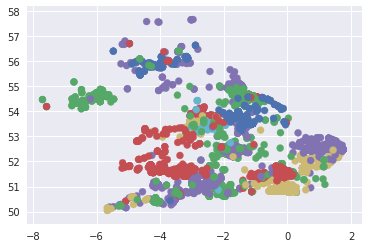

In [55]:
for pub in large_publishers:
    features = pub_feature_set[pub_feature_set["publisher"] == pub]
    color_map = [palette[p] for p in features["publisher"]]
    plt.scatter(features["lng"], features["lat"], color=color_map);


In [72]:
geolocator = geopy.Nominatim()

In [75]:
geolocator.geocode("West Midlands")

Location(West Midlands, Moyses Croft, Sandwell, West Midlands Combined Authority, West Midlands, England, B16, UK, (52.5050033, -1.96439612333127, 0.0))

In [56]:
pub = large_publishers[1]
features = pub_feature_set[pub_feature_set["publisher"] == pub]
features.sample(5)

,publisher,lat,lng,origin_type,name,nuts_region,local_government_area,id
4774,birminghammail,52.54791,-1.88421,Suburban Area,Kingstanding,West Midlands,Birmingham District,6671d403-140a-4520-84a9-bf00523a657b
8826,birminghammail,52.46716,-1.74383,Other Settlement,Marston Green,West Midlands,Solihull District,792f89c3-6633-4520-a433-c78f715876fe
909,birminghammail,52.50157,-1.96833,Suburban Area,Sandwell,West Midlands,Sandwell District,6dca2b14-982e-4ac9-a076-09f1f435abad
720,birminghammail,52.47182,-1.83181,Suburban Area,Bordesley Green East,West Midlands,Birmingham District,27d77cd5-844d-4dbe-a751-3f6c24197d19
1808,birminghammail,51.52920,-0.04670,Suburban Area,Globe Town,London,Tower Hamlets,64a6059e-458f-4a2b-9528-0f4e87cfc624


In [57]:
known_ids = set(features["id"].values)
all_ids = set(location_index.keys())

In [58]:
'b3e85189-5e04-4436-bed6-f92a4a9cc6c9' in location_index.keys()

True